# Setup

## Package Installation

In [ ]:
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
  Using cached torchvision-0.21.0-cp39-cp39-manylinux1_x86_64.whl (7.2 MB)
  Using cached torch-2.6.0-cp39-cp39-manylinux1_x86_64.whl (766.7 MB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl (56.3 MB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl (211.5 MB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl (188.7 MB)
  Using cached nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (99 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (24.6 MB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (13.8 MB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (883 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_6

In [ ]:
import numpy as np
from torchvision.datasets import CIFAR100
from collections import defaultdict
import random
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.models import resnet50

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using the device {}.'.format(device))
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda:0


## Utils

In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
clear_gpu_memory()

In [ ]:
def display_gpu_memory():
    # Display total GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # Display currently allocated memory
    print(f"Currently allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

    # Display cached memory (reserved by PyTorch but not used)
    print(f"Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
display_gpu_memory()

## Dataset

In [ ]:
# Get Dataset
dataset = CIFAR100(root='./data', train=True, download=True)
print(dataset)

with open('data/cifar-100-python/meta', 'rb') as fo:
    metadata = pickle.load(fo, encoding='bytes')

classLabels = dict(list(enumerate(metadata[b'fine_label_names'])))
print(classLabels)

100%|██████████| 169M/169M [00:01<00:00, 101MB/s]  


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
{0: b'apple', 1: b'aquarium_fish', 2: b'baby', 3: b'bear', 4: b'beaver', 5: b'bed', 6: b'bee', 7: b'beetle', 8: b'bicycle', 9: b'bottle', 10: b'bowl', 11: b'boy', 12: b'bridge', 13: b'bus', 14: b'butterfly', 15: b'camel', 16: b'can', 17: b'castle', 18: b'caterpillar', 19: b'cattle', 20: b'chair', 21: b'chimpanzee', 22: b'clock', 23: b'cloud', 24: b'cockroach', 25: b'couch', 26: b'crab', 27: b'crocodile', 28: b'cup', 29: b'dinosaur', 30: b'dolphin', 31: b'elephant', 32: b'flatfish', 33: b'forest', 34: b'fox', 35: b'girl', 36: b'hamster', 37: b'house', 38: b'kangaroo', 39: b'keyboard', 40: b'lamp', 41: b'lawn_mower', 42: b'leopard', 43: b'lion', 44: b'lizard', 45: b'lobster', 46: b'man', 47: b'maple_tree', 48: b'motorcycle', 49: b'mountain', 50: b'mouse', 51: b'mushroom', 52: b'oak_tree', 53: b'orange', 54: b'orchid', 55: b'otter', 56: b'palm_tree', 57: b'pear', 58: b'pickup_truck', 59: b'pine_tre

In [ ]:
with open('data/cifar-100-python/train', 'rb') as fo:
    trainMeta = pickle.load(fo, encoding='bytes')

with open('data/cifar-100-python/test', 'rb') as fo:
    testMeta = pickle.load(fo, encoding='bytes')


totalTest = len(testMeta[b'data'])
valNum = 4000

# Get training/testing data and labels
trainData = trainMeta[b'data']
trainData = trainData.reshape((len(trainData), 3, 32, 32))
trainLabel = np.array(trainMeta[b'fine_labels'])

mask = list(range(valNum))
valData = testMeta[b'data'][mask]
valData = valData.reshape((len(valData), 3, 32, 32))
valLabel = np.array(testMeta[b'fine_labels'])[mask]

mask = list(range(valNum, totalTest))
testData = testMeta[b'data'][mask]
testData = testData.reshape((len(testData), 3, 32, 32))
testLabel = np.array(testMeta[b'fine_labels'])[mask]

[500, 485, 470, 456, 442, 429, 416, 404, 392, 380, 369, 358, 347, 337, 327, 317, 308, 298, 290, 281, 272, 264, 256, 249, 241, 234, 227, 220, 214, 207, 201, 195, 189, 184, 178, 173, 168, 163, 158, 153, 149, 144, 140, 136, 132, 128, 124, 120, 116, 113, 110, 106, 103, 100, 97, 94, 91, 89, 86, 83, 81, 78, 76, 74, 72, 69, 67, 65, 63, 61, 60, 58, 56, 54, 53, 51, 50, 48, 47, 45, 44, 43, 41, 40, 39, 38, 37, 35, 34, 33, 32, 31, 30, 29, 29, 28, 27, 26, 25, 25]
15907


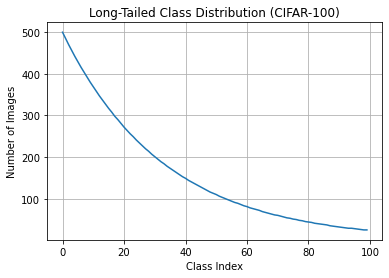

In [ ]:
# Get the number of images per class
imgPerClass = []

for cls in range(100):
    num = 500 * (0.05 ** (cls / 99))
    imgPerClass.append(int(num))

print(imgPerClass)
print(np.sum(imgPerClass))
plt.plot(imgPerClass)
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.title("Long-Tailed Class Distribution (CIFAR-100)")
plt.grid(True)
plt.show()

In [ ]:
# Get LT training data
trainDataLT, trainLabelLT = [], []
clsList = list(range(100))
random.shuffle(clsList)

for cls, numImg in enumerate(imgPerClass):
    clsIndx = np.where(trainLabel == clsList[cls])[0]
    numSampledImages = np.random.choice(clsIndx, numImg, replace=False)

    trainDataLT.append(trainData[numSampledImages])
    trainLabelLT.append(trainLabel[numSampledImages])

trainDataLT, trainLabelLT = np.concatenate(trainDataLT), np.concatenate(trainLabelLT)

# Training

In [ ]:
def train_model(trainData, valData, epochs: int, model=None, optimizer=None, scheduler=None, lossFunc=None, freq=200) -> None:

    for epoch in range(epochs):
        model.train()

        avgLoss = 0
        batchCorrect = 0
        batchNum = 0

        totalCorrect = 0
        totalNum = 0

        for i, batch in tqdm(enumerate(trainData)):
            data, labels = batch

            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(data)

            loss = lossFunc(output, labels)
            loss.backward()
            optimizer.step()

            avgLoss += loss.item()
            pred = torch.argmax(output, 1)

            batchCorrect += (pred == labels).sum().item()
            totalCorrect += (pred == labels).sum().item()
            totalNum += labels.size(0)
            batchNum += labels.size(0)

            if i % freq == 0:    # print every certain number of mini-batches
                avgLoss = avgLoss / freq
                accuracy = batchCorrect / batchNum
                last_lr = scheduler.get_last_lr()[0]
                print(f'[{epoch + 1}/{epochs}, {i + 1:5d}/{len(trainData)}] lr: {last_lr:.5f} loss: {avgLoss:.3f} acc: {accuracy:.3f}')
                avgLoss = 0.0
                batchCorrect = 0.0
                batchNum = 0.0

        scheduler.step()

        valAcc, _, _, _ = test_model(model, valData, True)
        trainAcc = totalCorrect / totalNum
        print(f'[{epoch + 1}/{epochs}] val acc: {valAcc:.3f} train acc: {trainAcc:.3f}')

        totalCorrect = 0
        totalNum = 0

# Testing

In [ ]:
def test_model(model, dataSet, classAcc=False):

    model.eval()
    correct = 0
    total = 0

    classCorrect = defaultdict(int)
    classTotal = defaultdict(int)

    with torch.no_grad():
        for batch_data in dataSet:
            images, labels = batch_data

            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            predicted = torch.argmax(output, 1)

            for label, pred in zip(labels, predicted):
                classTotal[label.item()] += 1
                if pred == label:
                    classCorrect[label.item()] += 1

                total += 1
                correct += (pred == label).item()

    acc = correct / total

    if classAcc:
        head = clsList[:30]
        mid = clsList[30:70]
        tail = clsList[70:]

        def groupAcc(group):
            return sum(classCorrect[c] for c in group) / sum(classTotal[c] for c in group)

        headAcc = groupAcc(head)
        midAcc = groupAcc(mid)
        tailAcc = groupAcc(tail)

        print(f"Test Accuracy - Overall: {100*acc:.2f}% | Head: {100*headAcc:.2f}% | Mid: {100*midAcc:.2f}% | Tail: {100*tailAcc:.2f}%")
        return acc, headAcc, midAcc, tailAcc

    return acc

# Base Model (ResNet-50)

In [ ]:
# LT Base Accuracy

# Model
modelLT = resnet50(num_classes=100)
modelLT.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
modelLT.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.SGD(modelLT.parameters(), lr=0.0001, momentum=0.7, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
loss = nn.CrossEntropyLoss()

# Train
modelLT.to(device)
train_model(trainLoader, valLoader, 10, modelLT, optimizer, scheduler, loss)

7it [00:00, 32.74it/s]

[1/10,     1/498] lr: 0.00010 loss: 0.024 acc: 0.000


210it [00:04, 47.25it/s]

[1/10,   201/498] lr: 0.00010 loss: 4.482 acc: 0.030


410it [00:08, 46.16it/s]

[1/10,   401/498] lr: 0.00010 loss: 4.315 acc: 0.035


498it [00:10, 46.00it/s]


Test Accuracy - Overall: 1.27% | Head: 4.13% | Mid: 0.06% | Tail: 0.00%
[1/10] val acc: 0.013 train acc: 0.034


4it [00:00, 39.92it/s]

[2/10,     1/498] lr: 0.00010 loss: 0.022 acc: 0.031


210it [00:04, 49.44it/s]

[2/10,   201/498] lr: 0.00010 loss: 4.278 acc: 0.036


407it [00:08, 48.63it/s]

[2/10,   401/498] lr: 0.00010 loss: 4.260 acc: 0.044


498it [00:10, 49.16it/s]


Test Accuracy - Overall: 2.15% | Head: 7.10% | Mid: 0.00% | Tail: 0.00%
[2/10] val acc: 0.021 train acc: 0.040


5it [00:00, 42.85it/s]

[3/10,     1/498] lr: 0.00009 loss: 0.022 acc: 0.000


205it [00:04, 41.87it/s]

[3/10,   201/498] lr: 0.00009 loss: 4.244 acc: 0.045


405it [00:09, 41.58it/s]

[3/10,   401/498] lr: 0.00009 loss: 4.252 acc: 0.040


498it [00:11, 41.99it/s]


Test Accuracy - Overall: 1.52% | Head: 5.03% | Mid: 0.00% | Tail: 0.00%
[3/10] val acc: 0.015 train acc: 0.042


0it [00:00, ?it/s]

[4/10,     1/498] lr: 0.00008 loss: 0.021 acc: 0.125


210it [00:04, 45.44it/s]

[4/10,   201/498] lr: 0.00008 loss: 4.238 acc: 0.045


410it [00:09, 45.79it/s]

[4/10,   401/498] lr: 0.00008 loss: 4.220 acc: 0.048


498it [00:11, 44.40it/s]


Test Accuracy - Overall: 1.82% | Head: 6.02% | Mid: 0.00% | Tail: 0.00%
[4/10] val acc: 0.018 train acc: 0.047


4it [00:00, 37.93it/s]

[5/10,     1/498] lr: 0.00007 loss: 0.020 acc: 0.062


209it [00:04, 44.86it/s]

[5/10,   201/498] lr: 0.00007 loss: 4.219 acc: 0.046


409it [00:09, 43.67it/s]

[5/10,   401/498] lr: 0.00007 loss: 4.203 acc: 0.048


498it [00:11, 43.47it/s]


Test Accuracy - Overall: 1.70% | Head: 5.61% | Mid: 0.00% | Tail: 0.00%
[5/10] val acc: 0.017 train acc: 0.047


0it [00:00, ?it/s]

[6/10,     1/498] lr: 0.00005 loss: 0.020 acc: 0.094


209it [00:04, 45.32it/s]

[6/10,   201/498] lr: 0.00005 loss: 4.203 acc: 0.052


409it [00:09, 44.78it/s]

[6/10,   401/498] lr: 0.00005 loss: 4.197 acc: 0.047


498it [00:11, 44.50it/s]


Test Accuracy - Overall: 2.08% | Head: 6.85% | Mid: 0.00% | Tail: 0.00%
[6/10] val acc: 0.021 train acc: 0.049


0it [00:00, ?it/s]

[7/10,     1/498] lr: 0.00003 loss: 0.021 acc: 0.062


210it [00:04, 48.04it/s]

[7/10,   201/498] lr: 0.00003 loss: 4.185 acc: 0.050


410it [00:08, 48.86it/s]

[7/10,   401/498] lr: 0.00003 loss: 4.188 acc: 0.050


498it [00:10, 48.05it/s]


Test Accuracy - Overall: 1.85% | Head: 6.11% | Mid: 0.00% | Tail: 0.00%
[7/10] val acc: 0.018 train acc: 0.049


0it [00:00, ?it/s]

[8/10,     1/498] lr: 0.00002 loss: 0.021 acc: 0.031


209it [00:04, 43.60it/s]

[8/10,   201/498] lr: 0.00002 loss: 4.184 acc: 0.050


409it [00:09, 43.31it/s]

[8/10,   401/498] lr: 0.00002 loss: 4.192 acc: 0.050


498it [00:11, 43.78it/s]


Test Accuracy - Overall: 2.17% | Head: 7.10% | Mid: 0.06% | Tail: 0.00%
[8/10] val acc: 0.022 train acc: 0.050


0it [00:00, ?it/s]

[9/10,     1/498] lr: 0.00001 loss: 0.021 acc: 0.031


209it [00:04, 43.63it/s]

[9/10,   201/498] lr: 0.00001 loss: 4.184 acc: 0.055


409it [00:09, 45.53it/s]

[9/10,   401/498] lr: 0.00001 loss: 4.175 acc: 0.051


498it [00:11, 43.92it/s]


Test Accuracy - Overall: 2.10% | Head: 6.85% | Mid: 0.06% | Tail: 0.00%
[9/10] val acc: 0.021 train acc: 0.051


4it [00:00, 33.22it/s]

[10/10,     1/498] lr: 0.00000 loss: 0.021 acc: 0.062


209it [00:04, 43.94it/s]

[10/10,   201/498] lr: 0.00000 loss: 4.186 acc: 0.051


409it [00:09, 44.16it/s]

[10/10,   401/498] lr: 0.00000 loss: 4.187 acc: 0.052


498it [00:11, 43.67it/s]


Test Accuracy - Overall: 1.77% | Head: 5.69% | Mid: 0.12% | Tail: 0.00%
[10/10] val acc: 0.018 train acc: 0.051


In [ ]:
# Cifar-100 LT Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainDataLT), torch.Tensor(trainLabelLT).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

9it [00:00, 42.99it/s]

[1/20,     1/498] lr: 0.01000 loss: 0.023 acc: 0.000


210it [00:04, 48.04it/s]

[1/20,   201/498] lr: 0.01000 loss: 5.200 acc: 0.038


410it [00:08, 48.92it/s]

[1/20,   401/498] lr: 0.01000 loss: 4.050 acc: 0.070


498it [00:10, 47.83it/s]


Test Accuracy - Overall: 3.15% | Head: 10.40% | Mid: 0.00% | Tail: 0.00%
[1/20] val acc: 0.032 train acc: 0.064


0it [00:00, ?it/s]

[2/20,     1/498] lr: 0.00994 loss: 0.019 acc: 0.156


205it [00:04, 41.20it/s]

[2/20,   201/498] lr: 0.00994 loss: 3.936 acc: 0.083


405it [00:09, 43.68it/s]

[2/20,   401/498] lr: 0.00994 loss: 3.832 acc: 0.100


498it [00:11, 41.71it/s]


Test Accuracy - Overall: 6.00% | Head: 18.89% | Mid: 0.69% | Tail: 0.00%
[2/20] val acc: 0.060 train acc: 0.094


5it [00:00, 41.57it/s]

[3/20,     1/498] lr: 0.00976 loss: 0.018 acc: 0.125


210it [00:04, 47.73it/s]

[3/20,   201/498] lr: 0.00976 loss: 3.724 acc: 0.113


410it [00:08, 47.52it/s]

[3/20,   401/498] lr: 0.00976 loss: 3.684 acc: 0.119


498it [00:10, 47.15it/s]


Test Accuracy - Overall: 5.62% | Head: 17.49% | Mid: 0.81% | Tail: 0.00%
[3/20] val acc: 0.056 train acc: 0.119


0it [00:00, ?it/s]

[4/20,     1/498] lr: 0.00946 loss: 0.017 acc: 0.156


209it [00:04, 46.97it/s]

[4/20,   201/498] lr: 0.00946 loss: 3.631 acc: 0.128


409it [00:08, 48.12it/s]

[4/20,   401/498] lr: 0.00946 loss: 3.555 acc: 0.148


498it [00:10, 46.72it/s]


Test Accuracy - Overall: 7.58% | Head: 20.96% | Mid: 3.06% | Tail: 0.00%
[4/20] val acc: 0.076 train acc: 0.140


0it [00:00, ?it/s]

[5/20,     1/498] lr: 0.00905 loss: 0.019 acc: 0.188


210it [00:04, 47.68it/s]

[5/20,   201/498] lr: 0.00905 loss: 3.487 acc: 0.158


410it [00:08, 48.06it/s]

[5/20,   401/498] lr: 0.00905 loss: 3.409 acc: 0.175


498it [00:10, 47.34it/s]


Test Accuracy - Overall: 8.95% | Head: 24.17% | Mid: 4.00% | Tail: 0.08%
[5/20] val acc: 0.089 train acc: 0.169


0it [00:00, ?it/s]

[6/20,     1/498] lr: 0.00854 loss: 0.015 acc: 0.188


209it [00:04, 43.81it/s]

[6/20,   201/498] lr: 0.00854 loss: 3.314 acc: 0.188


409it [00:09, 44.66it/s]

[6/20,   401/498] lr: 0.00854 loss: 3.274 acc: 0.198


498it [00:11, 43.99it/s]


Test Accuracy - Overall: 11.55% | Head: 25.08% | Mid: 9.61% | Tail: 0.34%
[6/20] val acc: 0.116 train acc: 0.195


0it [00:00, ?it/s]

[7/20,     1/498] lr: 0.00794 loss: 0.016 acc: 0.250


209it [00:04, 40.55it/s]

[7/20,   201/498] lr: 0.00794 loss: 3.173 acc: 0.210


409it [00:09, 42.01it/s]

[7/20,   401/498] lr: 0.00794 loss: 3.137 acc: 0.227


498it [00:11, 42.00it/s]


Test Accuracy - Overall: 14.30% | Head: 29.46% | Mid: 11.86% | Tail: 2.11%
[7/20] val acc: 0.143 train acc: 0.222


0it [00:00, ?it/s]

[8/20,     1/498] lr: 0.00727 loss: 0.014 acc: 0.344


205it [00:04, 41.63it/s]

[8/20,   201/498] lr: 0.00727 loss: 3.024 acc: 0.247


405it [00:09, 41.60it/s]

[8/20,   401/498] lr: 0.00727 loss: 2.941 acc: 0.260


498it [00:11, 41.63it/s]


Test Accuracy - Overall: 14.62% | Head: 29.46% | Mid: 12.11% | Tail: 2.87%
[8/20] val acc: 0.146 train acc: 0.255


0it [00:00, ?it/s]

[9/20,     1/498] lr: 0.00655 loss: 0.014 acc: 0.250


210it [00:04, 48.26it/s]

[9/20,   201/498] lr: 0.00655 loss: 2.839 acc: 0.280


410it [00:08, 47.87it/s]

[9/20,   401/498] lr: 0.00655 loss: 2.822 acc: 0.283


498it [00:10, 46.93it/s]


Test Accuracy - Overall: 15.57% | Head: 33.91% | Mid: 12.11% | Tail: 1.52%
[9/20] val acc: 0.156 train acc: 0.282


0it [00:00, ?it/s]

[10/20,     1/498] lr: 0.00578 loss: 0.012 acc: 0.375


205it [00:04, 40.87it/s]

[10/20,   201/498] lr: 0.00578 loss: 2.723 acc: 0.306


405it [00:09, 42.93it/s]

[10/20,   401/498] lr: 0.00578 loss: 2.690 acc: 0.315


498it [00:12, 41.29it/s]


Test Accuracy - Overall: 17.15% | Head: 36.63% | Mid: 13.80% | Tail: 1.77%
[10/20] val acc: 0.172 train acc: 0.311


4it [00:00, 36.47it/s]

[11/20,     1/498] lr: 0.00500 loss: 0.013 acc: 0.250


209it [00:04, 41.38it/s]

[11/20,   201/498] lr: 0.00500 loss: 2.527 acc: 0.353


409it [00:09, 42.73it/s]

[11/20,   401/498] lr: 0.00500 loss: 2.530 acc: 0.348


498it [00:11, 42.38it/s]


Test Accuracy - Overall: 20.32% | Head: 34.90% | Mid: 21.29% | Tail: 4.13%
[11/20] val acc: 0.203 train acc: 0.350


4it [00:00, 39.20it/s]

[12/20,     1/498] lr: 0.00422 loss: 0.013 acc: 0.344


209it [00:04, 44.39it/s]

[12/20,   201/498] lr: 0.00422 loss: 2.318 acc: 0.389


409it [00:09, 44.31it/s]

[12/20,   401/498] lr: 0.00422 loss: 2.317 acc: 0.390


498it [00:11, 43.91it/s]


Test Accuracy - Overall: 20.70% | Head: 36.80% | Mid: 19.98% | Tail: 5.23%
[12/20] val acc: 0.207 train acc: 0.388


4it [00:00, 33.66it/s]

[13/20,     1/498] lr: 0.00345 loss: 0.010 acc: 0.406


209it [00:04, 41.55it/s]

[13/20,   201/498] lr: 0.00345 loss: 2.093 acc: 0.435


409it [00:09, 43.42it/s]

[13/20,   401/498] lr: 0.00345 loss: 2.122 acc: 0.435


498it [00:11, 42.48it/s]


Test Accuracy - Overall: 24.15% | Head: 40.35% | Mid: 24.09% | Tail: 7.67%
[13/20] val acc: 0.241 train acc: 0.436


0it [00:00, ?it/s]

[14/20,     1/498] lr: 0.00273 loss: 0.009 acc: 0.469


209it [00:04, 44.31it/s]

[14/20,   201/498] lr: 0.00273 loss: 1.820 acc: 0.507


409it [00:09, 43.74it/s]

[14/20,   401/498] lr: 0.00273 loss: 1.821 acc: 0.500


498it [00:11, 43.42it/s]


Test Accuracy - Overall: 24.75% | Head: 41.67% | Mid: 23.91% | Tail: 8.60%
[14/20] val acc: 0.247 train acc: 0.502


0it [00:00, ?it/s]

[15/20,     1/498] lr: 0.00206 loss: 0.008 acc: 0.531


209it [00:04, 44.56it/s]

[15/20,   201/498] lr: 0.00206 loss: 1.484 acc: 0.586


409it [00:09, 44.66it/s]

[15/20,   401/498] lr: 0.00206 loss: 1.515 acc: 0.572


498it [00:11, 43.92it/s]


Test Accuracy - Overall: 24.80% | Head: 41.34% | Mid: 24.84% | Tail: 7.84%
[15/20] val acc: 0.248 train acc: 0.577


0it [00:00, ?it/s]

[16/20,     1/498] lr: 0.00146 loss: 0.005 acc: 0.781


209it [00:05, 41.57it/s]

[16/20,   201/498] lr: 0.00146 loss: 1.116 acc: 0.695


409it [00:09, 44.66it/s]

[16/20,   401/498] lr: 0.00146 loss: 1.127 acc: 0.680


498it [00:11, 42.40it/s]


Test Accuracy - Overall: 25.25% | Head: 42.90% | Mid: 24.72% | Tail: 7.93%
[16/20] val acc: 0.253 train acc: 0.687


5it [00:00, 44.03it/s]

[17/20,     1/498] lr: 0.00095 loss: 0.003 acc: 0.906


205it [00:04, 42.25it/s]

[17/20,   201/498] lr: 0.00095 loss: 0.770 acc: 0.800


405it [00:09, 43.27it/s]

[17/20,   401/498] lr: 0.00095 loss: 0.766 acc: 0.790


498it [00:11, 43.23it/s]


Test Accuracy - Overall: 25.37% | Head: 40.92% | Mid: 25.66% | Tail: 9.11%
[17/20] val acc: 0.254 train acc: 0.793


0it [00:00, ?it/s]

[18/20,     1/498] lr: 0.00054 loss: 0.004 acc: 0.719


209it [00:04, 43.61it/s]

[18/20,   201/498] lr: 0.00054 loss: 0.530 acc: 0.874


409it [00:09, 44.91it/s]

[18/20,   401/498] lr: 0.00054 loss: 0.508 acc: 0.871


498it [00:11, 43.77it/s]


Test Accuracy - Overall: 25.92% | Head: 41.67% | Mid: 25.84% | Tail: 9.95%
[18/20] val acc: 0.259 train acc: 0.872


0it [00:00, ?it/s]

[19/20,     1/498] lr: 0.00024 loss: 0.003 acc: 0.875


209it [00:04, 44.09it/s]

[19/20,   201/498] lr: 0.00024 loss: 0.357 acc: 0.929


409it [00:09, 44.81it/s]

[19/20,   401/498] lr: 0.00024 loss: 0.361 acc: 0.923


498it [00:11, 43.71it/s]


Test Accuracy - Overall: 25.97% | Head: 43.15% | Mid: 25.66% | Tail: 8.85%
[19/20] val acc: 0.260 train acc: 0.925


4it [00:00, 38.77it/s]

[20/20,     1/498] lr: 0.00006 loss: 0.002 acc: 0.969


209it [00:04, 44.97it/s]

[20/20,   201/498] lr: 0.00006 loss: 0.303 acc: 0.943


409it [00:09, 44.99it/s]

[20/20,   401/498] lr: 0.00006 loss: 0.300 acc: 0.947


498it [00:11, 44.36it/s]


Test Accuracy - Overall: 25.57% | Head: 42.33% | Mid: 25.28% | Tail: 8.85%
[20/20] val acc: 0.256 train acc: 0.944


In [ ]:
# Cifar-100 Accuracy

# Model
model = resnet50(num_classes=100)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainData), torch.Tensor(trainLabel).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss = nn.CrossEntropyLoss()

# Train
model.to(device)
train_model(trainLoader, valLoader, 20, model, optimizer, scheduler, loss)

9it [00:00, 40.17it/s]

[1/20,     1/1563] lr: 0.01000 loss: 0.024 acc: 0.000


209it [00:04, 47.77it/s]

[1/20,   201/1563] lr: 0.01000 loss: 5.207 acc: 0.022


409it [00:08, 48.04it/s]

[1/20,   401/1563] lr: 0.01000 loss: 4.499 acc: 0.023


609it [00:12, 45.58it/s]

[1/20,   601/1563] lr: 0.01000 loss: 4.399 acc: 0.032


809it [00:17, 45.60it/s]

[1/20,   801/1563] lr: 0.01000 loss: 4.306 acc: 0.042


1006it [00:21, 46.73it/s]

[1/20,  1001/1563] lr: 0.01000 loss: 4.190 acc: 0.050


1206it [00:25, 47.96it/s]

[1/20,  1201/1563] lr: 0.01000 loss: 4.109 acc: 0.059


1406it [00:29, 42.75it/s]

[1/20,  1401/1563] lr: 0.01000 loss: 4.023 acc: 0.068


1563it [00:33, 46.44it/s]


Test Accuracy - Overall: 8.05% | Head: 9.82% | Mid: 6.87% | Tail: 7.84%
[1/20] val acc: 0.081 train acc: 0.046


7it [00:00, 32.75it/s]

[2/20,     1/1563] lr: 0.00994 loss: 0.018 acc: 0.094


206it [00:05, 40.97it/s]

[2/20,   201/1563] lr: 0.00994 loss: 3.950 acc: 0.083


406it [00:09, 40.87it/s]

[2/20,   401/1563] lr: 0.00994 loss: 3.892 acc: 0.088


606it [00:14, 41.34it/s]

[2/20,   601/1563] lr: 0.00994 loss: 3.878 acc: 0.089


806it [00:19, 40.76it/s]

[2/20,   801/1563] lr: 0.00994 loss: 3.815 acc: 0.098


1006it [00:24, 41.65it/s]

[2/20,  1001/1563] lr: 0.00994 loss: 3.774 acc: 0.103


1206it [00:29, 41.53it/s]

[2/20,  1201/1563] lr: 0.00994 loss: 3.747 acc: 0.117


1406it [00:34, 41.24it/s]

[2/20,  1401/1563] lr: 0.00994 loss: 3.722 acc: 0.120


1563it [00:37, 41.19it/s]


Test Accuracy - Overall: 14.37% | Head: 13.37% | Mid: 14.98% | Tail: 14.59%
[2/20] val acc: 0.144 train acc: 0.103


0it [00:00, ?it/s]

[3/20,     1/1563] lr: 0.00976 loss: 0.022 acc: 0.062


209it [00:04, 48.28it/s]

[3/20,   201/1563] lr: 0.00976 loss: 3.655 acc: 0.133


410it [00:08, 48.30it/s]

[3/20,   401/1563] lr: 0.00976 loss: 3.607 acc: 0.138


609it [00:12, 49.95it/s]

[3/20,   601/1563] lr: 0.00976 loss: 3.578 acc: 0.145


809it [00:17, 48.22it/s]

[3/20,   801/1563] lr: 0.00976 loss: 3.525 acc: 0.154


1009it [00:21, 45.94it/s]

[3/20,  1001/1563] lr: 0.00976 loss: 3.533 acc: 0.154


1209it [00:25, 48.27it/s]

[3/20,  1201/1563] lr: 0.00976 loss: 3.471 acc: 0.170


1409it [00:30, 41.81it/s]

[3/20,  1401/1563] lr: 0.00976 loss: 3.473 acc: 0.163


1563it [00:33, 46.02it/s]


Test Accuracy - Overall: 17.85% | Head: 15.26% | Mid: 19.10% | Tail: 18.80%
[3/20] val acc: 0.178 train acc: 0.153


0it [00:00, ?it/s]

[4/20,     1/1563] lr: 0.00946 loss: 0.020 acc: 0.000


209it [00:04, 42.68it/s]

[4/20,   201/1563] lr: 0.00946 loss: 3.362 acc: 0.182


409it [00:09, 45.76it/s]

[4/20,   401/1563] lr: 0.00946 loss: 3.294 acc: 0.193


609it [00:13, 48.01it/s]

[4/20,   601/1563] lr: 0.00946 loss: 3.288 acc: 0.192


809it [00:17, 45.67it/s]

[4/20,   801/1563] lr: 0.00946 loss: 3.258 acc: 0.195


1009it [00:22, 42.94it/s]

[4/20,  1001/1563] lr: 0.00946 loss: 3.196 acc: 0.215


1209it [00:27, 41.59it/s]

[4/20,  1201/1563] lr: 0.00946 loss: 3.208 acc: 0.207


1410it [00:31, 45.82it/s]

[4/20,  1401/1563] lr: 0.00946 loss: 3.136 acc: 0.221


1563it [00:35, 44.32it/s]


Test Accuracy - Overall: 24.55% | Head: 21.20% | Mid: 27.40% | Tail: 24.11%
[4/20] val acc: 0.245 train acc: 0.204


9it [00:00, 39.08it/s]

[5/20,     1/1563] lr: 0.00905 loss: 0.013 acc: 0.312


209it [00:05, 41.33it/s]

[5/20,   201/1563] lr: 0.00905 loss: 3.036 acc: 0.240


409it [00:09, 41.59it/s]

[5/20,   401/1563] lr: 0.00905 loss: 3.034 acc: 0.252


609it [00:14, 43.92it/s]

[5/20,   601/1563] lr: 0.00905 loss: 2.986 acc: 0.255


809it [00:19, 44.50it/s]

[5/20,   801/1563] lr: 0.00905 loss: 2.907 acc: 0.272


1009it [00:23, 44.81it/s]

[5/20,  1001/1563] lr: 0.00905 loss: 2.879 acc: 0.279


1209it [00:27, 46.48it/s]

[5/20,  1201/1563] lr: 0.00905 loss: 2.879 acc: 0.269


1409it [00:32, 47.56it/s]

[5/20,  1401/1563] lr: 0.00905 loss: 2.820 acc: 0.280


1563it [00:35, 44.12it/s]


Test Accuracy - Overall: 29.80% | Head: 24.67% | Mid: 31.65% | Tail: 32.55%
[5/20] val acc: 0.298 train acc: 0.266


0it [00:00, ?it/s]

[6/20,     1/1563] lr: 0.00854 loss: 0.015 acc: 0.281


207it [00:05, 42.06it/s]

[6/20,   201/1563] lr: 0.00854 loss: 2.611 acc: 0.325


407it [00:09, 42.45it/s]

[6/20,   401/1563] lr: 0.00854 loss: 2.640 acc: 0.322


607it [00:14, 41.07it/s]

[6/20,   601/1563] lr: 0.00854 loss: 2.639 acc: 0.315


807it [00:19, 42.33it/s]

[6/20,   801/1563] lr: 0.00854 loss: 2.582 acc: 0.334


1007it [00:24, 41.42it/s]

[6/20,  1001/1563] lr: 0.00854 loss: 2.571 acc: 0.329


1207it [00:28, 46.82it/s]

[6/20,  1201/1563] lr: 0.00854 loss: 2.601 acc: 0.323


1407it [00:32, 46.50it/s]

[6/20,  1401/1563] lr: 0.00854 loss: 2.516 acc: 0.347


1563it [00:36, 43.02it/s]


Test Accuracy - Overall: 33.15% | Head: 26.73% | Mid: 36.33% | Tail: 35.41%
[6/20] val acc: 0.332 train acc: 0.329


0it [00:00, ?it/s]

[7/20,     1/1563] lr: 0.00794 loss: 0.012 acc: 0.281


209it [00:04, 41.78it/s]

[7/20,   201/1563] lr: 0.00794 loss: 2.327 acc: 0.382


409it [00:09, 41.79it/s]

[7/20,   401/1563] lr: 0.00794 loss: 2.358 acc: 0.372


609it [00:14, 41.23it/s]

[7/20,   601/1563] lr: 0.00794 loss: 2.319 acc: 0.388


809it [00:19, 41.04it/s]

[7/20,   801/1563] lr: 0.00794 loss: 2.348 acc: 0.372


1009it [00:24, 41.06it/s]

[7/20,  1001/1563] lr: 0.00794 loss: 2.335 acc: 0.376


1209it [00:28, 42.96it/s]

[7/20,  1201/1563] lr: 0.00794 loss: 2.299 acc: 0.393


1409it [00:33, 40.67it/s]

[7/20,  1401/1563] lr: 0.00794 loss: 2.315 acc: 0.396


1563it [00:37, 41.52it/s]


Test Accuracy - Overall: 39.35% | Head: 33.25% | Mid: 42.07% | Tail: 41.91%
[7/20] val acc: 0.394 train acc: 0.384


0it [00:00, ?it/s]

[8/20,     1/1563] lr: 0.00727 loss: 0.009 acc: 0.375


209it [00:04, 46.22it/s]

[8/20,   201/1563] lr: 0.00727 loss: 2.072 acc: 0.444


409it [00:08, 46.11it/s]

[8/20,   401/1563] lr: 0.00727 loss: 2.078 acc: 0.434


610it [00:13, 45.12it/s]

[8/20,   601/1563] lr: 0.00727 loss: 2.089 acc: 0.438


810it [00:17, 48.39it/s]

[8/20,   801/1563] lr: 0.00727 loss: 2.080 acc: 0.431


1010it [00:21, 47.97it/s]

[8/20,  1001/1563] lr: 0.00727 loss: 2.089 acc: 0.428


1210it [00:25, 48.06it/s]

[8/20,  1201/1563] lr: 0.00727 loss: 2.027 acc: 0.443


1410it [00:29, 48.22it/s]

[8/20,  1401/1563] lr: 0.00727 loss: 2.074 acc: 0.438


1563it [00:33, 47.22it/s]


Test Accuracy - Overall: 40.33% | Head: 35.15% | Mid: 42.88% | Tail: 42.16%
[8/20] val acc: 0.403 train acc: 0.438


0it [00:00, ?it/s]

[9/20,     1/1563] lr: 0.00655 loss: 0.009 acc: 0.500


209it [00:04, 43.79it/s]

[9/20,   201/1563] lr: 0.00655 loss: 1.793 acc: 0.500


409it [00:09, 43.04it/s]

[9/20,   401/1563] lr: 0.00655 loss: 1.811 acc: 0.504


609it [00:14, 42.89it/s]

[9/20,   601/1563] lr: 0.00655 loss: 1.808 acc: 0.497


809it [00:18, 43.89it/s]

[9/20,   801/1563] lr: 0.00655 loss: 1.831 acc: 0.495


1009it [00:23, 42.04it/s]

[9/20,  1001/1563] lr: 0.00655 loss: 1.832 acc: 0.494


1209it [00:28, 41.40it/s]

[9/20,  1201/1563] lr: 0.00655 loss: 1.808 acc: 0.500


1409it [00:32, 43.57it/s]

[9/20,  1401/1563] lr: 0.00655 loss: 1.797 acc: 0.504


1563it [00:36, 42.78it/s]


Test Accuracy - Overall: 45.70% | Head: 38.70% | Mid: 47.63% | Tail: 50.25%
[9/20] val acc: 0.457 train acc: 0.500


0it [00:00, ?it/s]

[10/20,     1/1563] lr: 0.00578 loss: 0.005 acc: 0.625


207it [00:04, 43.61it/s]

[10/20,   201/1563] lr: 0.00578 loss: 1.527 acc: 0.565


407it [00:09, 44.09it/s]

[10/20,   401/1563] lr: 0.00578 loss: 1.528 acc: 0.570


607it [00:13, 44.17it/s]

[10/20,   601/1563] lr: 0.00578 loss: 1.542 acc: 0.561


807it [00:18, 43.83it/s]

[10/20,   801/1563] lr: 0.00578 loss: 1.552 acc: 0.564


1007it [00:23, 44.92it/s]

[10/20,  1001/1563] lr: 0.00578 loss: 1.585 acc: 0.552


1207it [00:27, 44.65it/s]

[10/20,  1201/1563] lr: 0.00578 loss: 1.537 acc: 0.563


1407it [00:32, 43.06it/s]

[10/20,  1401/1563] lr: 0.00578 loss: 1.570 acc: 0.557


1563it [00:35, 43.61it/s]


Test Accuracy - Overall: 47.25% | Head: 42.24% | Mid: 48.69% | Tail: 50.42%
[10/20] val acc: 0.472 train acc: 0.562


9it [00:00, 42.32it/s]

[11/20,     1/1563] lr: 0.00500 loss: 0.005 acc: 0.719


209it [00:04, 48.44it/s]

[11/20,   201/1563] lr: 0.00500 loss: 1.200 acc: 0.649


409it [00:08, 48.95it/s]

[11/20,   401/1563] lr: 0.00500 loss: 1.239 acc: 0.643


609it [00:12, 48.78it/s]

[11/20,   601/1563] lr: 0.00500 loss: 1.255 acc: 0.628


809it [00:17, 40.89it/s]

[11/20,   801/1563] lr: 0.00500 loss: 1.277 acc: 0.633


1009it [00:21, 43.44it/s]

[11/20,  1001/1563] lr: 0.00500 loss: 1.267 acc: 0.636


1209it [00:26, 42.37it/s]

[11/20,  1201/1563] lr: 0.00500 loss: 1.304 acc: 0.625


1409it [00:31, 40.93it/s]

[11/20,  1401/1563] lr: 0.00500 loss: 1.320 acc: 0.624


1563it [00:34, 44.73it/s]


Test Accuracy - Overall: 49.68% | Head: 42.33% | Mid: 51.50% | Tail: 54.72%
[11/20] val acc: 0.497 train acc: 0.633


0it [00:00, ?it/s]

[12/20,     1/1563] lr: 0.00422 loss: 0.005 acc: 0.688


209it [00:04, 41.69it/s]

[12/20,   201/1563] lr: 0.00422 loss: 0.912 acc: 0.737


409it [00:09, 42.59it/s]

[12/20,   401/1563] lr: 0.00422 loss: 0.894 acc: 0.733


609it [00:14, 41.31it/s]

[12/20,   601/1563] lr: 0.00422 loss: 0.940 acc: 0.729


809it [00:19, 42.17it/s]

[12/20,   801/1563] lr: 0.00422 loss: 0.934 acc: 0.720


1009it [00:23, 44.84it/s]

[12/20,  1001/1563] lr: 0.00422 loss: 1.001 acc: 0.697


1209it [00:28, 43.14it/s]

[12/20,  1201/1563] lr: 0.00422 loss: 1.007 acc: 0.703


1409it [00:33, 41.40it/s]

[12/20,  1401/1563] lr: 0.00422 loss: 1.004 acc: 0.706


1563it [00:36, 42.39it/s]


Test Accuracy - Overall: 49.93% | Head: 42.49% | Mid: 51.50% | Tail: 55.40%
[12/20] val acc: 0.499 train acc: 0.716


0it [00:00, ?it/s]

[13/20,     1/1563] lr: 0.00345 loss: 0.002 acc: 0.844


208it [00:04, 42.65it/s]

[13/20,   201/1563] lr: 0.00345 loss: 0.636 acc: 0.812


408it [00:09, 40.09it/s]

[13/20,   401/1563] lr: 0.00345 loss: 0.632 acc: 0.810


608it [00:14, 44.58it/s]

[13/20,   601/1563] lr: 0.00345 loss: 0.643 acc: 0.805


808it [00:18, 42.89it/s]

[13/20,   801/1563] lr: 0.00345 loss: 0.673 acc: 0.796


1008it [00:23, 43.16it/s]

[13/20,  1001/1563] lr: 0.00345 loss: 0.655 acc: 0.803


1208it [00:28, 43.13it/s]

[13/20,  1201/1563] lr: 0.00345 loss: 0.694 acc: 0.787


1408it [00:33, 41.47it/s]

[13/20,  1401/1563] lr: 0.00345 loss: 0.705 acc: 0.787


1563it [00:36, 42.39it/s]


Test Accuracy - Overall: 50.12% | Head: 44.97% | Mid: 51.12% | Tail: 54.05%
[13/20] val acc: 0.501 train acc: 0.798


0it [00:00, ?it/s]

[14/20,     1/1563] lr: 0.00273 loss: 0.001 acc: 0.906


209it [00:04, 45.17it/s]

[14/20,   201/1563] lr: 0.00273 loss: 0.399 acc: 0.887


409it [00:09, 44.92it/s]

[14/20,   401/1563] lr: 0.00273 loss: 0.384 acc: 0.885


606it [00:13, 46.82it/s]

[14/20,   601/1563] lr: 0.00273 loss: 0.419 acc: 0.880


806it [00:17, 47.85it/s]

[14/20,   801/1563] lr: 0.00273 loss: 0.403 acc: 0.883


1006it [00:21, 44.96it/s]

[14/20,  1001/1563] lr: 0.00273 loss: 0.419 acc: 0.876


1206it [00:26, 44.95it/s]

[14/20,  1201/1563] lr: 0.00273 loss: 0.417 acc: 0.872


1406it [00:30, 47.75it/s]

[14/20,  1401/1563] lr: 0.00273 loss: 0.427 acc: 0.870


1563it [00:34, 45.79it/s]


Test Accuracy - Overall: 49.45% | Head: 41.58% | Mid: 52.12% | Tail: 53.88%
[14/20] val acc: 0.494 train acc: 0.876


8it [00:00, 36.97it/s]

[15/20,     1/1563] lr: 0.00206 loss: 0.001 acc: 0.938


207it [00:04, 43.03it/s]

[15/20,   201/1563] lr: 0.00206 loss: 0.237 acc: 0.937


407it [00:09, 43.34it/s]

[15/20,   401/1563] lr: 0.00206 loss: 0.215 acc: 0.944


607it [00:14, 42.93it/s]

[15/20,   601/1563] lr: 0.00206 loss: 0.221 acc: 0.938


807it [00:19, 42.58it/s]

[15/20,   801/1563] lr: 0.00206 loss: 0.226 acc: 0.938


1007it [00:23, 42.15it/s]

[15/20,  1001/1563] lr: 0.00206 loss: 0.240 acc: 0.929


1207it [00:28, 40.54it/s]

[15/20,  1201/1563] lr: 0.00206 loss: 0.251 acc: 0.928


1407it [00:33, 42.40it/s]

[15/20,  1401/1563] lr: 0.00206 loss: 0.240 acc: 0.931


1563it [00:37, 41.95it/s]


Test Accuracy - Overall: 49.93% | Head: 43.98% | Mid: 50.19% | Tail: 55.65%
[15/20] val acc: 0.499 train acc: 0.934


0it [00:00, ?it/s]

[16/20,     1/1563] lr: 0.00146 loss: 0.000 acc: 1.000


205it [00:04, 41.04it/s]

[16/20,   201/1563] lr: 0.00146 loss: 0.133 acc: 0.968


405it [00:09, 43.12it/s]

[16/20,   401/1563] lr: 0.00146 loss: 0.122 acc: 0.972


607it [00:14, 47.52it/s]

[16/20,   601/1563] lr: 0.00146 loss: 0.121 acc: 0.971


807it [00:18, 41.21it/s]

[16/20,   801/1563] lr: 0.00146 loss: 0.132 acc: 0.967


1007it [00:23, 43.63it/s]

[16/20,  1001/1563] lr: 0.00146 loss: 0.116 acc: 0.971


1207it [00:28, 39.75it/s]

[16/20,  1201/1563] lr: 0.00146 loss: 0.144 acc: 0.961


1407it [00:32, 47.20it/s]

[16/20,  1401/1563] lr: 0.00146 loss: 0.132 acc: 0.964


1563it [00:36, 43.35it/s]


Test Accuracy - Overall: 50.48% | Head: 44.47% | Mid: 51.19% | Tail: 55.65%
[16/20] val acc: 0.505 train acc: 0.967


0it [00:00, ?it/s]

[17/20,     1/1563] lr: 0.00095 loss: 0.000 acc: 1.000


209it [00:04, 47.75it/s]

[17/20,   201/1563] lr: 0.00095 loss: 0.076 acc: 0.985


409it [00:08, 47.68it/s]

[17/20,   401/1563] lr: 0.00095 loss: 0.068 acc: 0.987


609it [00:13, 47.10it/s]

[17/20,   601/1563] lr: 0.00095 loss: 0.070 acc: 0.987


809it [00:17, 48.50it/s]

[17/20,   801/1563] lr: 0.00095 loss: 0.069 acc: 0.985


1009it [00:21, 46.34it/s]

[17/20,  1001/1563] lr: 0.00095 loss: 0.064 acc: 0.988


1209it [00:25, 47.37it/s]

[17/20,  1201/1563] lr: 0.00095 loss: 0.064 acc: 0.989


1409it [00:29, 47.26it/s]

[17/20,  1401/1563] lr: 0.00095 loss: 0.073 acc: 0.985


1563it [00:33, 46.85it/s]


Test Accuracy - Overall: 50.85% | Head: 44.64% | Mid: 51.87% | Tail: 55.82%
[17/20] val acc: 0.508 train acc: 0.987


8it [00:00, 37.02it/s]

[18/20,     1/1563] lr: 0.00054 loss: 0.000 acc: 1.000


206it [00:05, 39.75it/s]

[18/20,   201/1563] lr: 0.00054 loss: 0.046 acc: 0.993


407it [00:10, 42.00it/s]

[18/20,   401/1563] lr: 0.00054 loss: 0.047 acc: 0.993


607it [00:14, 41.27it/s]

[18/20,   601/1563] lr: 0.00054 loss: 0.043 acc: 0.993


807it [00:19, 42.75it/s]

[18/20,   801/1563] lr: 0.00054 loss: 0.041 acc: 0.993


1007it [00:24, 43.81it/s]

[18/20,  1001/1563] lr: 0.00054 loss: 0.042 acc: 0.994


1207it [00:28, 43.38it/s]

[18/20,  1201/1563] lr: 0.00054 loss: 0.045 acc: 0.992


1407it [00:33, 40.82it/s]

[18/20,  1401/1563] lr: 0.00054 loss: 0.045 acc: 0.993


1563it [00:37, 41.56it/s]


Test Accuracy - Overall: 51.08% | Head: 45.13% | Mid: 52.06% | Tail: 55.82%
[18/20] val acc: 0.511 train acc: 0.993


0it [00:00, ?it/s]

[19/20,     1/1563] lr: 0.00024 loss: 0.000 acc: 1.000


209it [00:04, 42.29it/s]

[19/20,   201/1563] lr: 0.00024 loss: 0.037 acc: 0.993


409it [00:09, 43.18it/s]

[19/20,   401/1563] lr: 0.00024 loss: 0.031 acc: 0.997


609it [00:14, 41.83it/s]

[19/20,   601/1563] lr: 0.00024 loss: 0.030 acc: 0.997


809it [00:19, 41.72it/s]

[19/20,   801/1563] lr: 0.00024 loss: 0.032 acc: 0.995


1004it [00:23, 40.44it/s]

[19/20,  1001/1563] lr: 0.00024 loss: 0.029 acc: 0.997


1209it [00:28, 44.33it/s]

[19/20,  1201/1563] lr: 0.00024 loss: 0.031 acc: 0.995


1409it [00:33, 44.48it/s]

[19/20,  1401/1563] lr: 0.00024 loss: 0.033 acc: 0.996


1563it [00:37, 42.22it/s]


Test Accuracy - Overall: 50.72% | Head: 44.14% | Mid: 52.43% | Tail: 55.14%
[19/20] val acc: 0.507 train acc: 0.996


0it [00:00, ?it/s]

[20/20,     1/1563] lr: 0.00006 loss: 0.000 acc: 1.000


207it [00:04, 47.54it/s]

[20/20,   201/1563] lr: 0.00006 loss: 0.024 acc: 0.998


409it [00:08, 43.44it/s]

[20/20,   401/1563] lr: 0.00006 loss: 0.025 acc: 0.998


609it [00:13, 45.91it/s]

[20/20,   601/1563] lr: 0.00006 loss: 0.028 acc: 0.997


809it [00:17, 40.48it/s]

[20/20,   801/1563] lr: 0.00006 loss: 0.027 acc: 0.998


1009it [00:22, 42.31it/s]

[20/20,  1001/1563] lr: 0.00006 loss: 0.025 acc: 0.997


1207it [00:27, 43.39it/s]

[20/20,  1201/1563] lr: 0.00006 loss: 0.024 acc: 0.998


1407it [00:31, 44.43it/s]

[20/20,  1401/1563] lr: 0.00006 loss: 0.027 acc: 0.997


1563it [00:35, 44.36it/s]


Test Accuracy - Overall: 50.82% | Head: 44.14% | Mid: 52.43% | Tail: 55.48%
[20/20] val acc: 0.508 train acc: 0.997


# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class tempModel(nn.Module):
    def __init__(self):
        super(tempModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # CIFAR-100 32x32 input with 3x3 feature map after pooling
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 100)  # 100 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)  # equivalent to softmax + cross-entropy


model = tempModel()
model.to(device)

# Train/Val Set
trainSet = torch.utils.data.TensorDataset(torch.Tensor(trainData), torch.Tensor(trainLabel).long())
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=2)
valSet = torch.utils.data.TensorDataset(torch.Tensor(valData), torch.Tensor(valLabel))
valLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=2)

# Params
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
loss = nn.CrossEntropyLoss()

# Train
cifar100_model.to(device)
train_model(trainLoader, valLoader, 30, model, optimizer, scheduler, loss)

41it [00:00, 203.00it/s]

[1/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.031


235it [00:01, 234.32it/s]

[1/30,   201/1563] lr: 0.01000 loss: 4.627 acc: 0.011


434it [00:01, 240.73it/s]

[1/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.009


634it [00:02, 243.28it/s]

[1/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.011


834it [00:03, 241.92it/s]

[1/30,   801/1563] lr: 0.01000 loss: 4.609 acc: 0.011


1034it [00:04, 245.74it/s]

[1/30,  1001/1563] lr: 0.01000 loss: 4.611 acc: 0.008


1234it [00:05, 243.24it/s]

[1/30,  1201/1563] lr: 0.01000 loss: 4.610 acc: 0.007


1434it [00:06, 240.17it/s]

[1/30,  1401/1563] lr: 0.01000 loss: 4.611 acc: 0.011


1563it [00:06, 235.92it/s]


Test Accuracy - Overall: 0.90% | Head: 0.00% | Mid: 2.25% | Tail: 0.00%
[1/30] val acc: 0.009 train acc: 0.010


0it [00:00, ?it/s]

[2/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


239it [00:01, 205.29it/s]

[2/30,   201/1563] lr: 0.01000 loss: 4.609 acc: 0.009


432it [00:02, 211.85it/s]

[2/30,   401/1563] lr: 0.01000 loss: 4.612 acc: 0.007


625it [00:03, 198.38it/s]

[2/30,   601/1563] lr: 0.01000 loss: 4.610 acc: 0.011


826it [00:04, 192.37it/s]

[2/30,   801/1563] lr: 0.01000 loss: 4.612 acc: 0.008


1024it [00:05, 179.06it/s]

[2/30,  1001/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1235it [00:06, 180.13it/s]

[2/30,  1201/1563] lr: 0.01000 loss: 4.610 acc: 0.009


1419it [00:07, 195.41it/s]

[2/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.010


1563it [00:08, 194.35it/s]


Test Accuracy - Overall: 0.90% | Head: 2.97% | Mid: 0.00% | Tail: 0.00%
[2/30] val acc: 0.009 train acc: 0.009


0it [00:00, ?it/s]

[3/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


233it [00:01, 179.16it/s]

[3/30,   201/1563] lr: 0.01000 loss: 4.611 acc: 0.006


427it [00:02, 194.68it/s]

[3/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.010


643it [00:03, 214.83it/s]

[3/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.010


820it [00:04, 190.79it/s]

[3/30,   801/1563] lr: 0.01000 loss: 4.614 acc: 0.010


1020it [00:05, 183.98it/s]

[3/30,  1001/1563] lr: 0.01000 loss: 4.610 acc: 0.008


1232it [00:06, 184.71it/s]

[3/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.011


1424it [00:07, 189.04it/s]

[3/30,  1401/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1563it [00:08, 191.25it/s]


Test Accuracy - Overall: 0.70% | Head: 0.00% | Mid: 1.75% | Tail: 0.00%
[3/30] val acc: 0.007 train acc: 0.009


0it [00:00, ?it/s]

[4/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


231it [00:01, 208.02it/s]

[4/30,   201/1563] lr: 0.01000 loss: 4.610 acc: 0.010


424it [00:02, 200.48it/s]

[4/30,   401/1563] lr: 0.01000 loss: 4.611 acc: 0.010


629it [00:03, 202.50it/s]

[4/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.010


834it [00:04, 195.37it/s]

[4/30,   801/1563] lr: 0.01000 loss: 4.610 acc: 0.009


1029it [00:05, 186.76it/s]

[4/30,  1001/1563] lr: 0.01000 loss: 4.610 acc: 0.009


1235it [00:06, 184.22it/s]

[4/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1433it [00:07, 192.83it/s]

[4/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.010


1563it [00:08, 188.67it/s]


Test Accuracy - Overall: 1.12% | Head: 3.71% | Mid: 0.00% | Tail: 0.00%
[4/30] val acc: 0.011 train acc: 0.010


0it [00:00, ?it/s]

[5/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.031


229it [00:01, 202.15it/s]

[5/30,   201/1563] lr: 0.01000 loss: 4.609 acc: 0.011


427it [00:02, 202.63it/s]

[5/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.008


634it [00:03, 198.77it/s]

[5/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.010


826it [00:04, 213.26it/s]

[5/30,   801/1563] lr: 0.01000 loss: 4.610 acc: 0.011


1038it [00:05, 202.04it/s]

[5/30,  1001/1563] lr: 0.01000 loss: 4.610 acc: 0.011


1228it [00:06, 202.01it/s]

[5/30,  1201/1563] lr: 0.01000 loss: 4.612 acc: 0.008


1439it [00:07, 202.75it/s]

[5/30,  1401/1563] lr: 0.01000 loss: 4.611 acc: 0.010


1563it [00:07, 200.01it/s]


Test Accuracy - Overall: 0.80% | Head: 0.00% | Mid: 2.00% | Tail: 0.00%
[5/30] val acc: 0.008 train acc: 0.010


0it [00:00, ?it/s]

[6/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.031


229it [00:01, 200.14it/s]

[6/30,   201/1563] lr: 0.01000 loss: 4.610 acc: 0.010


426it [00:02, 213.05it/s]

[6/30,   401/1563] lr: 0.01000 loss: 4.611 acc: 0.008


635it [00:03, 200.75it/s]

[6/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.010


837it [00:04, 190.79it/s]

[6/30,   801/1563] lr: 0.01000 loss: 4.610 acc: 0.011


1033it [00:05, 179.02it/s]

[6/30,  1001/1563] lr: 0.01000 loss: 4.610 acc: 0.009


1221it [00:06, 181.36it/s]

[6/30,  1201/1563] lr: 0.01000 loss: 4.612 acc: 0.010


1432it [00:07, 175.25it/s]

[6/30,  1401/1563] lr: 0.01000 loss: 4.611 acc: 0.010


1563it [00:08, 189.28it/s]


Test Accuracy - Overall: 0.95% | Head: 0.00% | Mid: 0.00% | Tail: 3.20%
[6/30] val acc: 0.009 train acc: 0.010


0it [00:00, ?it/s]

[7/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


226it [00:00, 257.93it/s]

[7/30,   201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


436it [00:01, 219.54it/s]

[7/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.009


635it [00:02, 214.63it/s]

[7/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.009


836it [00:03, 219.40it/s]

[7/30,   801/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1043it [00:04, 221.51it/s]

[7/30,  1001/1563] lr: 0.01000 loss: 4.610 acc: 0.010


1224it [00:05, 216.65it/s]

[7/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1426it [00:06, 214.70it/s]

[7/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.010


1563it [00:07, 215.33it/s]


Test Accuracy - Overall: 1.23% | Head: 0.00% | Mid: 3.06% | Tail: 0.00%
[7/30] val acc: 0.012 train acc: 0.010


0it [00:00, ?it/s]

[8/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


226it [00:01, 222.90it/s]

[8/30,   201/1563] lr: 0.01000 loss: 4.609 acc: 0.008


433it [00:01, 220.09it/s]

[8/30,   401/1563] lr: 0.01000 loss: 4.611 acc: 0.009


636it [00:02, 220.08it/s]

[8/30,   601/1563] lr: 0.01000 loss: 4.610 acc: 0.011


837it [00:03, 217.52it/s]

[8/30,   801/1563] lr: 0.01000 loss: 4.611 acc: 0.010


1040it [00:04, 218.95it/s]

[8/30,  1001/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1240it [00:05, 218.24it/s]

[8/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1440it [00:06, 219.18it/s]

[8/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.011


1563it [00:07, 215.58it/s]


Test Accuracy - Overall: 1.15% | Head: 0.00% | Mid: 2.87% | Tail: 0.00%
[8/30] val acc: 0.011 train acc: 0.010


0it [00:00, ?it/s]

[9/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


242it [00:01, 240.38it/s]

[9/30,   201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


442it [00:01, 243.65it/s]

[9/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.011


642it [00:02, 245.82it/s]

[9/30,   601/1563] lr: 0.01000 loss: 4.610 acc: 0.009


842it [00:03, 244.61it/s]

[9/30,   801/1563] lr: 0.01000 loss: 4.610 acc: 0.010


1041it [00:04, 238.87it/s]

[9/30,  1001/1563] lr: 0.01000 loss: 4.612 acc: 0.011


1241it [00:05, 237.23it/s]

[9/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1441it [00:05, 245.34it/s]

[9/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.008


1563it [00:06, 238.80it/s]


Test Accuracy - Overall: 1.00% | Head: 3.30% | Mid: 0.00% | Tail: 0.00%
[9/30] val acc: 0.010 train acc: 0.010


0it [00:00, ?it/s]

[10/30,     1/1563] lr: 0.01000 loss: 0.023 acc: 0.000


229it [00:00, 247.59it/s]

[10/30,   201/1563] lr: 0.01000 loss: 4.611 acc: 0.011


446it [00:01, 228.37it/s]

[10/30,   401/1563] lr: 0.01000 loss: 4.610 acc: 0.011


631it [00:02, 228.22it/s]

[10/30,   601/1563] lr: 0.01000 loss: 4.611 acc: 0.010


837it [00:03, 217.91it/s]

[10/30,   801/1563] lr: 0.01000 loss: 4.611 acc: 0.008


1035it [00:04, 203.68it/s]

[10/30,  1001/1563] lr: 0.01000 loss: 4.609 acc: 0.010


1231it [00:05, 217.63it/s]

[10/30,  1201/1563] lr: 0.01000 loss: 4.611 acc: 0.009


1428it [00:06, 209.68it/s]

[10/30,  1401/1563] lr: 0.01000 loss: 4.610 acc: 0.008


1563it [00:07, 214.35it/s]


Test Accuracy - Overall: 0.60% | Head: 0.00% | Mid: 0.00% | Tail: 2.02%
[10/30] val acc: 0.006 train acc: 0.010


0it [00:00, ?it/s]

[11/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


237it [00:01, 188.14it/s]

[11/30,   201/1563] lr: 0.00300 loss: 4.607 acc: 0.013


430it [00:02, 187.38it/s]

[11/30,   401/1563] lr: 0.00300 loss: 4.608 acc: 0.011


633it [00:03, 217.27it/s]

[11/30,   601/1563] lr: 0.00300 loss: 4.608 acc: 0.008


840it [00:04, 224.27it/s]

[11/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1024it [00:04, 222.15it/s]

[11/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.007


1224it [00:05, 202.55it/s]

[11/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.011


1431it [00:06, 200.67it/s]

[11/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1563it [00:07, 199.13it/s]


Test Accuracy - Overall: 1.03% | Head: 3.38% | Mid: 0.00% | Tail: 0.00%
[11/30] val acc: 0.010 train acc: 0.009


0it [00:00, ?it/s]

[12/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.062


241it [00:00, 270.24it/s]

[12/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.009


438it [00:01, 274.01it/s]

[12/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.007


637it [00:02, 277.83it/s]

[12/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.009


837it [00:03, 278.33it/s]

[12/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.012


1038it [00:03, 278.08it/s]

[12/30,  1001/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1234it [00:04, 268.28it/s]

[12/30,  1201/1563] lr: 0.00300 loss: 4.608 acc: 0.010


1436it [00:05, 272.80it/s]

[12/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1563it [00:05, 268.02it/s]


Test Accuracy - Overall: 1.03% | Head: 0.00% | Mid: 2.56% | Tail: 0.00%
[12/30] val acc: 0.010 train acc: 0.009


0it [00:00, ?it/s]

[13/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.031


243it [00:01, 222.65it/s]

[13/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.010


427it [00:01, 221.63it/s]

[13/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.009


634it [00:02, 224.72it/s]

[13/30,   601/1563] lr: 0.00300 loss: 4.606 acc: 0.010


839it [00:03, 213.93it/s]

[13/30,   801/1563] lr: 0.00300 loss: 4.608 acc: 0.008


1030it [00:04, 203.38it/s]

[13/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.008


1236it [00:05, 191.02it/s]

[13/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1426it [00:06, 210.49it/s]

[13/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1563it [00:07, 205.70it/s]


Test Accuracy - Overall: 1.05% | Head: 3.47% | Mid: 0.00% | Tail: 0.00%
[13/30] val acc: 0.011 train acc: 0.009


0it [00:00, ?it/s]

[14/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


225it [00:00, 251.75it/s]

[14/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.010


443it [00:01, 227.02it/s]

[14/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


624it [00:02, 215.78it/s]

[14/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.009


830it [00:03, 230.22it/s]

[14/30,   801/1563] lr: 0.00300 loss: 4.606 acc: 0.006


1024it [00:04, 232.25it/s]

[14/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.010


1240it [00:05, 223.08it/s]

[14/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1431it [00:06, 223.00it/s]

[14/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1563it [00:06, 225.16it/s]


Test Accuracy - Overall: 0.95% | Head: 0.00% | Mid: 0.00% | Tail: 3.20%
[14/30] val acc: 0.009 train acc: 0.009


0it [00:00, ?it/s]

[15/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


236it [00:01, 182.85it/s]

[15/30,   201/1563] lr: 0.00300 loss: 4.607 acc: 0.008


422it [00:02, 193.48it/s]

[15/30,   401/1563] lr: 0.00300 loss: 4.606 acc: 0.009


632it [00:03, 202.14it/s]

[15/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.010


828it [00:04, 212.74it/s]

[15/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1039it [00:05, 198.57it/s]

[15/30,  1001/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1230it [00:06, 193.12it/s]

[15/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1428it [00:07, 194.40it/s]

[15/30,  1401/1563] lr: 0.00300 loss: 4.608 acc: 0.007


1563it [00:08, 193.92it/s]


Test Accuracy - Overall: 1.23% | Head: 0.00% | Mid: 3.06% | Tail: 0.00%
[15/30] val acc: 0.012 train acc: 0.008


0it [00:00, ?it/s]

[16/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


231it [00:00, 266.61it/s]

[16/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.009


453it [00:01, 275.34it/s]

[16/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.011


637it [00:02, 248.94it/s]

[16/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.008


841it [00:03, 228.04it/s]

[16/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1033it [00:04, 222.90it/s]

[16/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.010


1243it [00:05, 217.28it/s]

[16/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1427it [00:05, 227.70it/s]

[16/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1563it [00:06, 234.66it/s]


Test Accuracy - Overall: 1.23% | Head: 0.00% | Mid: 3.06% | Tail: 0.00%
[16/30] val acc: 0.012 train acc: 0.009


0it [00:00, ?it/s]

[17/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


227it [00:01, 188.98it/s]

[17/30,   201/1563] lr: 0.00300 loss: 4.607 acc: 0.010


426it [00:02, 204.80it/s]

[17/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.008


636it [00:03, 194.98it/s]

[17/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.010


834it [00:04, 201.07it/s]

[17/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.007


1032it [00:05, 189.87it/s]

[17/30,  1001/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1228it [00:06, 188.91it/s]

[17/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1420it [00:07, 184.01it/s]

[17/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1563it [00:08, 187.60it/s]


Test Accuracy - Overall: 0.85% | Head: 0.00% | Mid: 2.12% | Tail: 0.00%
[17/30] val acc: 0.009 train acc: 0.009


0it [00:00, ?it/s]

[18/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


224it [00:01, 207.81it/s]

[18/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.010


424it [00:02, 215.85it/s]

[18/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.009


623it [00:02, 217.23it/s]

[18/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.011


825it [00:03, 219.01it/s]

[18/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1025it [00:04, 217.27it/s]

[18/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.009


1227it [00:05, 219.15it/s]

[18/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1429it [00:06, 217.59it/s]

[18/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1563it [00:07, 210.94it/s]


Test Accuracy - Overall: 1.00% | Head: 3.30% | Mid: 0.00% | Tail: 0.00%
[18/30] val acc: 0.010 train acc: 0.010


0it [00:00, ?it/s]

[19/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


224it [00:01, 216.70it/s]

[19/30,   201/1563] lr: 0.00300 loss: 4.606 acc: 0.009


422it [00:01, 209.27it/s]

[19/30,   401/1563] lr: 0.00300 loss: 4.606 acc: 0.010


630it [00:02, 224.83it/s]

[19/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.010


826it [00:03, 203.21it/s]

[19/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1041it [00:04, 205.11it/s]

[19/30,  1001/1563] lr: 0.00300 loss: 4.608 acc: 0.010


1234it [00:05, 202.86it/s]

[19/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1431it [00:06, 212.00it/s]

[19/30,  1401/1563] lr: 0.00300 loss: 4.608 acc: 0.006


1563it [00:07, 208.69it/s]


Test Accuracy - Overall: 0.95% | Head: 0.00% | Mid: 2.37% | Tail: 0.00%
[19/30] val acc: 0.009 train acc: 0.009


0it [00:00, ?it/s]

[20/30,     1/1563] lr: 0.00300 loss: 0.023 acc: 0.000


231it [00:01, 210.66it/s]

[20/30,   201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


429it [00:02, 206.63it/s]

[20/30,   401/1563] lr: 0.00300 loss: 4.607 acc: 0.010


631it [00:03, 194.47it/s]

[20/30,   601/1563] lr: 0.00300 loss: 4.607 acc: 0.009


825it [00:04, 185.01it/s]

[20/30,   801/1563] lr: 0.00300 loss: 4.607 acc: 0.008


1022it [00:05, 194.55it/s]

[20/30,  1001/1563] lr: 0.00300 loss: 4.607 acc: 0.010


1222it [00:06, 188.42it/s]

[20/30,  1201/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1427it [00:07, 200.62it/s]

[20/30,  1401/1563] lr: 0.00300 loss: 4.607 acc: 0.009


1563it [00:08, 192.59it/s]


Test Accuracy - Overall: 1.05% | Head: 0.00% | Mid: 2.62% | Tail: 0.00%
[20/30] val acc: 0.011 train acc: 0.009


0it [00:00, ?it/s]

[21/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


223it [00:01, 214.94it/s]

[21/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.011


431it [00:02, 188.23it/s]

[21/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.010


629it [00:03, 203.32it/s]

[21/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.008


831it [00:04, 196.56it/s]

[21/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1033it [00:05, 195.88it/s]

[21/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.006


1236it [00:06, 191.04it/s]

[21/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1423it [00:07, 193.54it/s]

[21/30,  1401/1563] lr: 0.00090 loss: 4.607 acc: 0.008


1563it [00:08, 195.33it/s]


Test Accuracy - Overall: 1.00% | Head: 0.00% | Mid: 2.50% | Tail: 0.00%
[21/30] val acc: 0.010 train acc: 0.009


0it [00:00, ?it/s]

[22/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.062


225it [00:01, 197.47it/s]

[22/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.009


428it [00:02, 177.98it/s]

[22/30,   401/1563] lr: 0.00090 loss: 4.605 acc: 0.012


622it [00:03, 173.30it/s]

[22/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.009


836it [00:04, 178.92it/s]

[22/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1029it [00:05, 184.67it/s]

[22/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1217it [00:06, 162.28it/s]

[22/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1428it [00:08, 187.69it/s]

[22/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.007


1563it [00:08, 175.14it/s]


Test Accuracy - Overall: 1.07% | Head: 0.00% | Mid: 0.00% | Tail: 3.63%
[22/30] val acc: 0.011 train acc: 0.009


0it [00:00, ?it/s]

[23/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


239it [00:01, 192.58it/s]

[23/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.011


422it [00:02, 168.13it/s]

[23/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.007


630it [00:03, 210.67it/s]

[23/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.010


829it [00:04, 159.87it/s]

[23/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1026it [00:05, 211.37it/s]

[23/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1222it [00:06, 165.77it/s]

[23/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.010


1426it [00:07, 166.96it/s]

[23/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.007


1563it [00:08, 179.18it/s]


Test Accuracy - Overall: 0.92% | Head: 0.00% | Mid: 2.31% | Tail: 0.00%
[23/30] val acc: 0.009 train acc: 0.009


0it [00:00, ?it/s]

[24/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


241it [00:01, 213.81it/s]

[24/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.011


433it [00:02, 178.45it/s]

[24/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.009


619it [00:03, 159.01it/s]

[24/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.009


828it [00:04, 155.10it/s]

[24/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1021it [00:05, 157.69it/s]

[24/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1230it [00:07, 156.78it/s]

[24/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.010


1423it [00:08, 151.43it/s]

[24/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.006


1563it [00:09, 167.10it/s]


Test Accuracy - Overall: 1.00% | Head: 0.00% | Mid: 2.50% | Tail: 0.00%
[24/30] val acc: 0.010 train acc: 0.009


0it [00:00, ?it/s]

[25/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


237it [00:01, 211.34it/s]

[25/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.010


426it [00:01, 232.27it/s]

[25/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.009


639it [00:02, 209.78it/s]

[25/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.010


830it [00:03, 199.29it/s]

[25/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1027it [00:04, 213.96it/s]

[25/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1227it [00:05, 211.45it/s]

[25/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1426it [00:06, 217.11it/s]

[25/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1563it [00:07, 210.66it/s]


Test Accuracy - Overall: 1.00% | Head: 0.00% | Mid: 2.50% | Tail: 0.00%
[25/30] val acc: 0.010 train acc: 0.009


0it [00:00, ?it/s]

[26/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


232it [00:01, 216.06it/s]

[26/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.010


432it [00:02, 213.20it/s]

[26/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.009


631it [00:02, 213.50it/s]

[26/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.008


830it [00:03, 213.08it/s]

[26/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1025it [00:04, 212.45it/s]

[26/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1240it [00:05, 206.44it/s]

[26/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.007


1429it [00:06, 199.22it/s]

[26/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.007


1563it [00:07, 204.25it/s]


Test Accuracy - Overall: 0.90% | Head: 0.00% | Mid: 0.00% | Tail: 3.04%
[26/30] val acc: 0.009 train acc: 0.008


0it [00:00, ?it/s]

[27/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.062


238it [00:01, 213.45it/s]

[27/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.009


444it [00:02, 224.04it/s]

[27/30,   401/1563] lr: 0.00090 loss: 4.605 acc: 0.011


628it [00:02, 222.06it/s]

[27/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.009


839it [00:03, 225.58it/s]

[27/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.010


1020it [00:04, 206.96it/s]

[27/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1217it [00:05, 169.52it/s]

[27/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1434it [00:07, 177.47it/s]

[27/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1563it [00:07, 197.86it/s]


Test Accuracy - Overall: 1.23% | Head: 0.00% | Mid: 0.00% | Tail: 4.13%
[27/30] val acc: 0.012 train acc: 0.009


0it [00:00, ?it/s]

[28/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


225it [00:01, 208.77it/s]

[28/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.010


421it [00:02, 197.06it/s]

[28/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.009


626it [00:03, 205.56it/s]

[28/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.010


829it [00:03, 215.58it/s]

[28/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1033it [00:04, 212.16it/s]

[28/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1235it [00:05, 222.74it/s]

[28/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1437it [00:06, 216.49it/s]

[28/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1563it [00:07, 204.91it/s]


Test Accuracy - Overall: 1.05% | Head: 0.00% | Mid: 0.00% | Tail: 3.54%
[28/30] val acc: 0.011 train acc: 0.009


0it [00:00, ?it/s]

[29/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


229it [00:01, 200.33it/s]

[29/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.010


447it [00:02, 238.06it/s]

[29/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.011


645it [00:02, 233.18it/s]

[29/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.008


841it [00:03, 236.22it/s]

[29/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1048it [00:04, 253.12it/s]

[29/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.011


1231it [00:05, 255.15it/s]

[29/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.007


1439it [00:06, 234.94it/s]

[29/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.006


1563it [00:06, 230.77it/s]


Test Accuracy - Overall: 1.05% | Head: 0.00% | Mid: 0.00% | Tail: 3.54%
[29/30] val acc: 0.011 train acc: 0.009


0it [00:00, ?it/s]

[30/30,     1/1563] lr: 0.00090 loss: 0.023 acc: 0.000


224it [00:01, 193.72it/s]

[30/30,   201/1563] lr: 0.00090 loss: 4.605 acc: 0.012


433it [00:02, 208.61it/s]

[30/30,   401/1563] lr: 0.00090 loss: 4.606 acc: 0.010


643it [00:03, 225.17it/s]

[30/30,   601/1563] lr: 0.00090 loss: 4.606 acc: 0.009


834it [00:04, 195.15it/s]

[30/30,   801/1563] lr: 0.00090 loss: 4.606 acc: 0.011


1038it [00:05, 195.07it/s]

[30/30,  1001/1563] lr: 0.00090 loss: 4.606 acc: 0.009


1222it [00:06, 197.59it/s]

[30/30,  1201/1563] lr: 0.00090 loss: 4.606 acc: 0.006


1430it [00:07, 202.68it/s]

[30/30,  1401/1563] lr: 0.00090 loss: 4.606 acc: 0.008


1563it [00:07, 198.61it/s]


Test Accuracy - Overall: 0.95% | Head: 3.14% | Mid: 0.00% | Tail: 0.00%
[30/30] val acc: 0.009 train acc: 0.009
